# 0.0. IMPORTS


In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import pickle
import warnings
import inflection

from sklearn.linear_model  import Lasso
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



## 0.1 Helper Funcions

In [3]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] ) 
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/vicente/repos/Ds-producao/.Ds-producao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loaging data

In [5]:
#carregamento dos csv 

df_sales_raw = pd.read_csv('data/train.csv', low_memory=False )
df_store_raw = pd.read_csv('data/store.csv', low_memory=False )

#merge
#união dos df store e df sales
df_raw = pd.merge(df_sales_raw, df_store_raw, how ='left', on='Store')



# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [6]:
#copia do df
df1 = df_raw.copy()


## 1.1.  Rename Columns

In [7]:
#remoneação das colunas 

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
             'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
              'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new  = list (map(snakecase, cols_old))

#remane 
df1.columns = cols_new


## 1.2. Data Dimensions 

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0]))
print( 'Number of cols: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [9]:
#tipos de dados de cada coluna
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()
#linhas com NA

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#df1['competition_distance'].max()

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
692739,1110,6,2013-10-19,2541,334,1,0,0,0,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN


In [14]:
#competition_distance           
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)
##substituir os NA da competition distance acima do valor maximo, usar o lambda para criar a função, usra o apply para aplicar nas colunas, substituir essa coluna 
#na coluna original.


#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1 )
# se a coluna for NA irá extrair o mês dela, se não for era permanecer. por fim sobre escreve a coluna original


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )



#promo2_since_week    
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )


#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )


#promo_interval  
month_map = {1: 'jan', 2: 'fev', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec', }

df1['promo_interval'].fillna(0, inplace=True)
#coluna com NA igual a zero (inplace true não retorna valor modifica na propria coluna)

df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
#quebrar as linhas com split, ver se o elemento da coluna esta na lista, se sim retorna 1 se não retorna 0, se promo_interval for igual a 0 retorno 0 se nãp volto igual a 1
#promo_interval e month_map como filtros





In [15]:
df1.sample(5).T

,145,94361,907710,642327,919656
store,146,702,886,873,567
day_of_week,5,5,2,2,5
date,2015-07-31 00:00:00,2015-05-08 00:00:00,2013-04-09 00:00:00,2013-12-03 00:00:00,2013-03-29 00:00:00
sales,10130,5892,7758,5554,0
customers,784,412,669,607,0
open,1,1,1,1,0
promo,1,1,1,1,1
state_holiday,0,0,0,0,b
school_holiday,1,0,0,0,1
store_type,d,a,a,a,c


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. CHange Types

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
 
cat_attributes = df1.select_dtypes(exclude = ['int64','float64', 'datetime64[ns]']) 

## 1.7.1 Numeriacal Attributes

In [19]:
# skew deformação da distribuicao em relação a normal, mais para esquerda skew positiva, mais para esquerda skew negativa

#kurtosis concentração dos dados, quando positiva mais dados concentrados, pico alto, mais disperso negativo 


In [20]:
# central tendency - maen , median 
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T



# Dispersion - atd, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate (concatenar = unir)
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


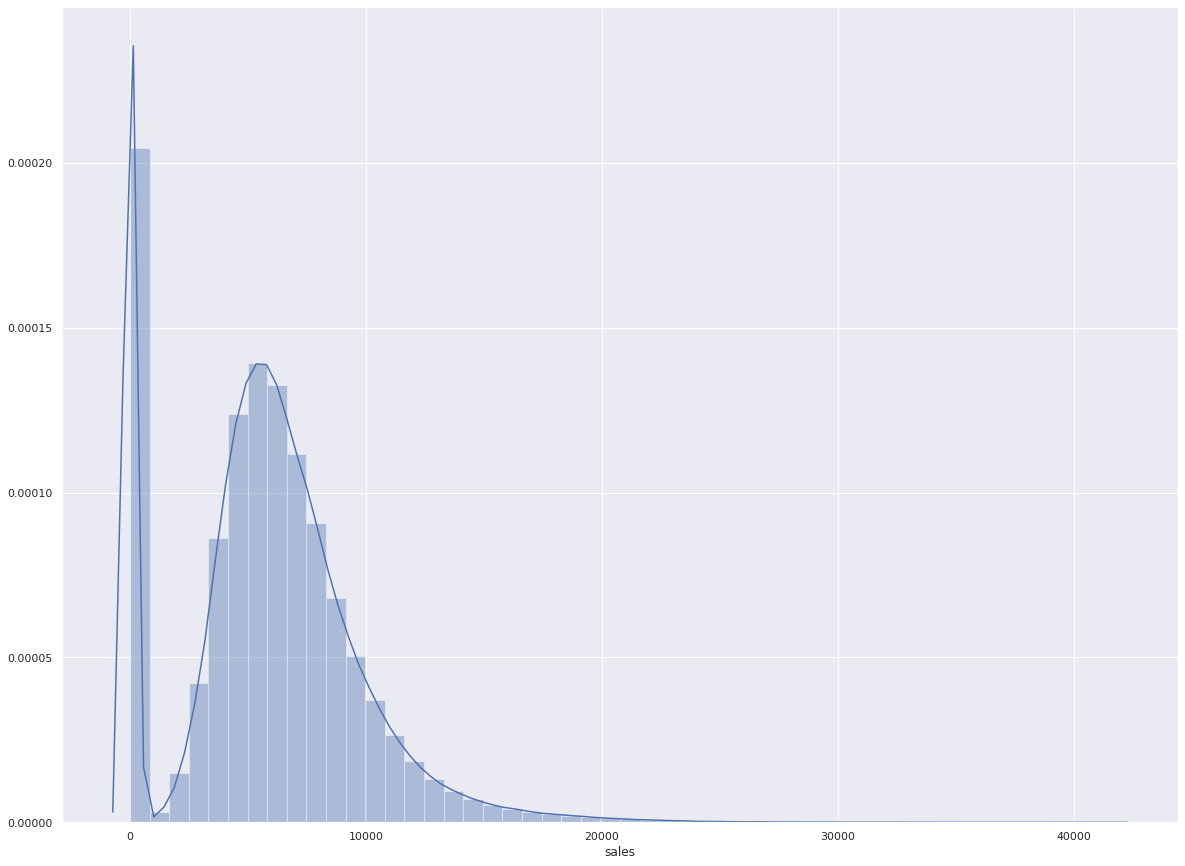

In [21]:
fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

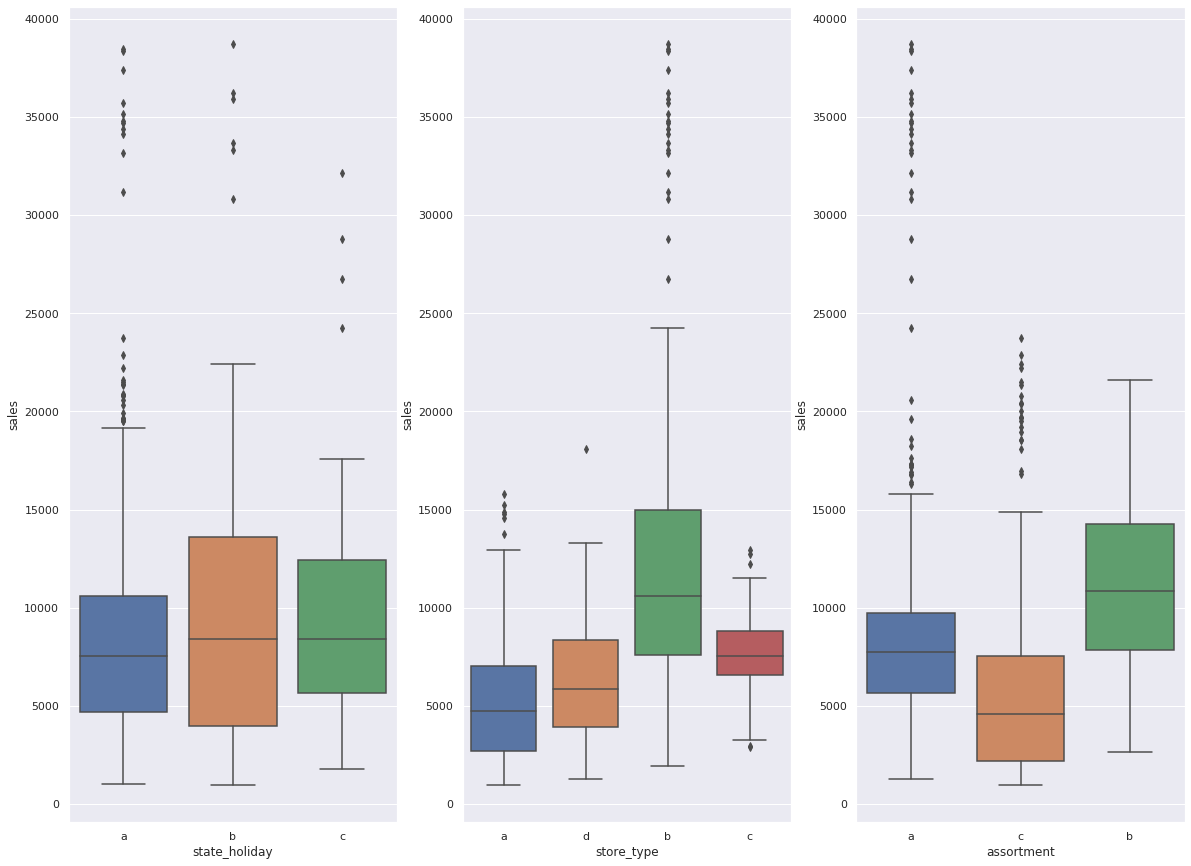

In [23]:
#auxiliar satate_holiday diferente de 0 e vendes acima de 0
fig, ax = plt.subplots(figsize=(20,15))

aux1 = df1[(df1['state_holiday'] !='0')  & (df1['sales']>0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales',data=aux1)
figsize=(10)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales',data=aux1)
figsize=(10)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales',data=aux1)
figsize=(10)


# 2. PASSO 02 - FEATURE ENGINEERING 

In [24]:
df2 = df1.copy()

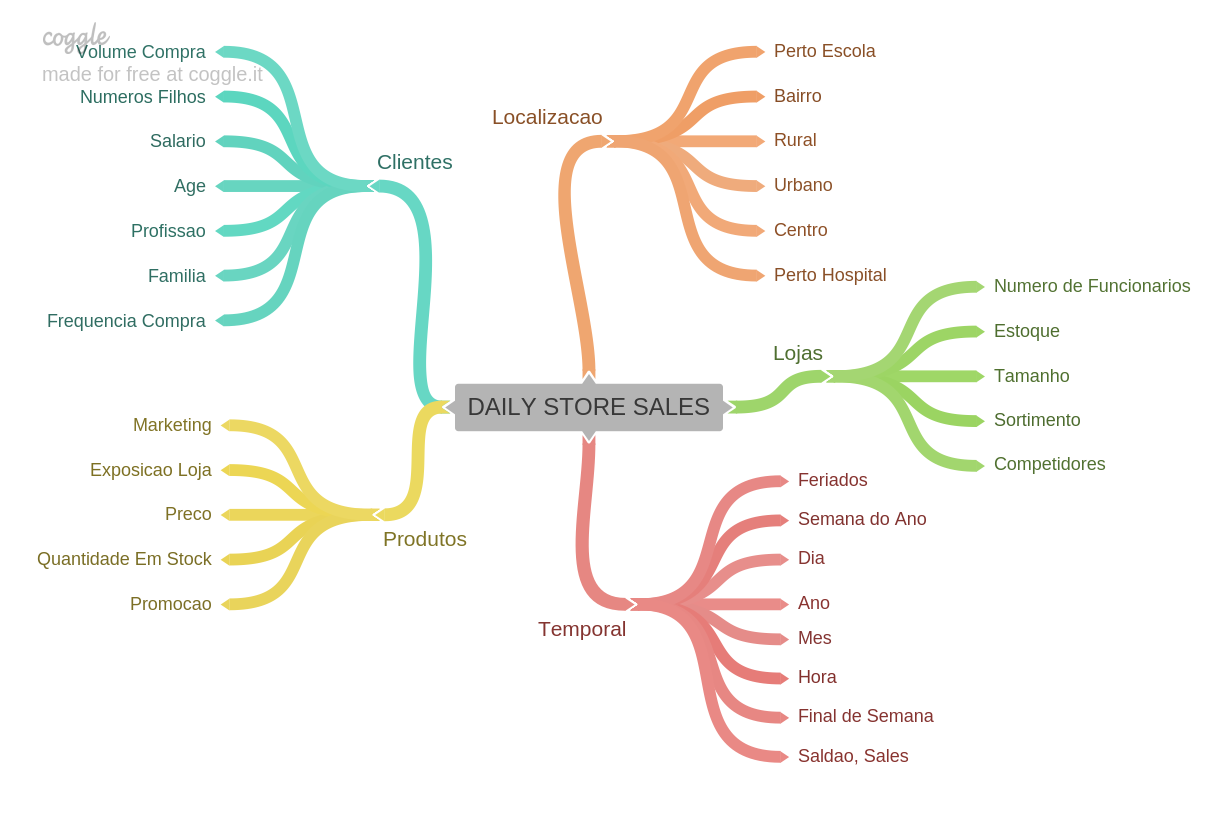

In [25]:
Image('img/MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.

2. Lojas com maior capacidade de estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

4. Lojas com maior sortimentos deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.1. Hipoteses Produto 

1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas com maior exposição de produto deveriam vender mais.

3. Lojas com produtos com preço menor deveriam vender mais.

5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

6. Lojas com promoções ativas por mais tempo deveriam vender mais.

7. Lojas com mais dias de promoção deveriam vender mais.

8. Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.1. Hipoteses tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo semestre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista final de Hipóteses

### 2.4. Feature Engeneering

In [26]:
# **year**
df2['year'] = df2['date'].dt.year #(metodo dt datetime que extrai o year)
#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year 
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%y-%w') #(metodo ftime mudar o formato da data)

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
#( juntar as duas colunas usa-se o metodo datetime determeina o year(competition_year), o month(competition_month) e day )
df2['competition_time_month']=((df2['date']- df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
#(subtrair date do con_since, dividir por 30, aplicar a funçãp day e converter para int)

#promo since
df2['promo_since'] = df2['competition_since']= df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#(subtrair a coluna year com a coluna week e converter para str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days =7))
#(aplicar a função timedelta e subtrair 7 dias)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply (lambda x:'basic' if x== 'a' else 'extra' if x=='b' else 'extended')
#(se x for igual a retorno basic, se x for igual a b retorno extra, senao retorno extended)

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday' if x=='a' else 'easte_holiday' if x=='b'else 'christmas' if x=='c' else 'regular_day')

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0.PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [28]:
df3=df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,jul,0,2015,7,31,31,15-5,2015-31,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",jul,0,2015,7,31,31,15-5,2010-13,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",jul,0,2015,7,31,31,15-5,2011-14,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,jul,0,2015,7,31,31,15-5,2015-31,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,jul,0,2015,7,31,31,15-5,2015-31,4,2015-07-27,0


In [30]:
#df3.isna().sum()

 ## 3.1. FIltragem das Linhas 

In [31]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] >0)]

## 3.2. Selecao das colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3= df3.drop(cols_drop, axis=1)

In [33]:
#df3.columns

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [34]:
df4 = df3.copy()

In [35]:
df4.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
is_promo                        0
year                            0
month                           0
day                             0
week_of_year                    0
year_week                       0
competition_since               0
competition_time_month          0
promo_since                     0
promo_time_week                 0
dtype: int64

## 4.1 Analise Univariada

### 4.1.1 Response Variable

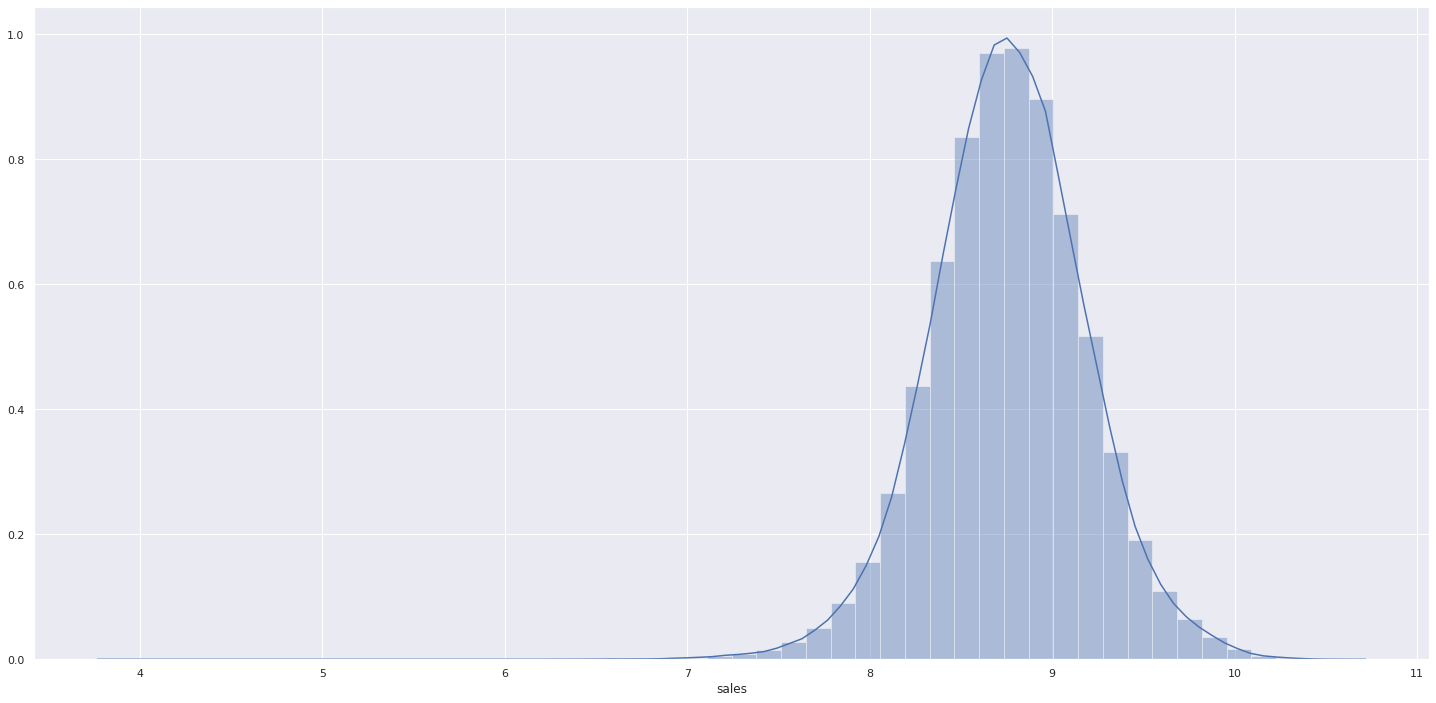

In [36]:
#log1p deica a variavel comdistribuiçao mais perto do nomal 
#fig,ax=plt.subplots(figsize=(20,15))
sns.distplot(np.log1p(df4['sales']))


### 4.1.2 Numeral Variable

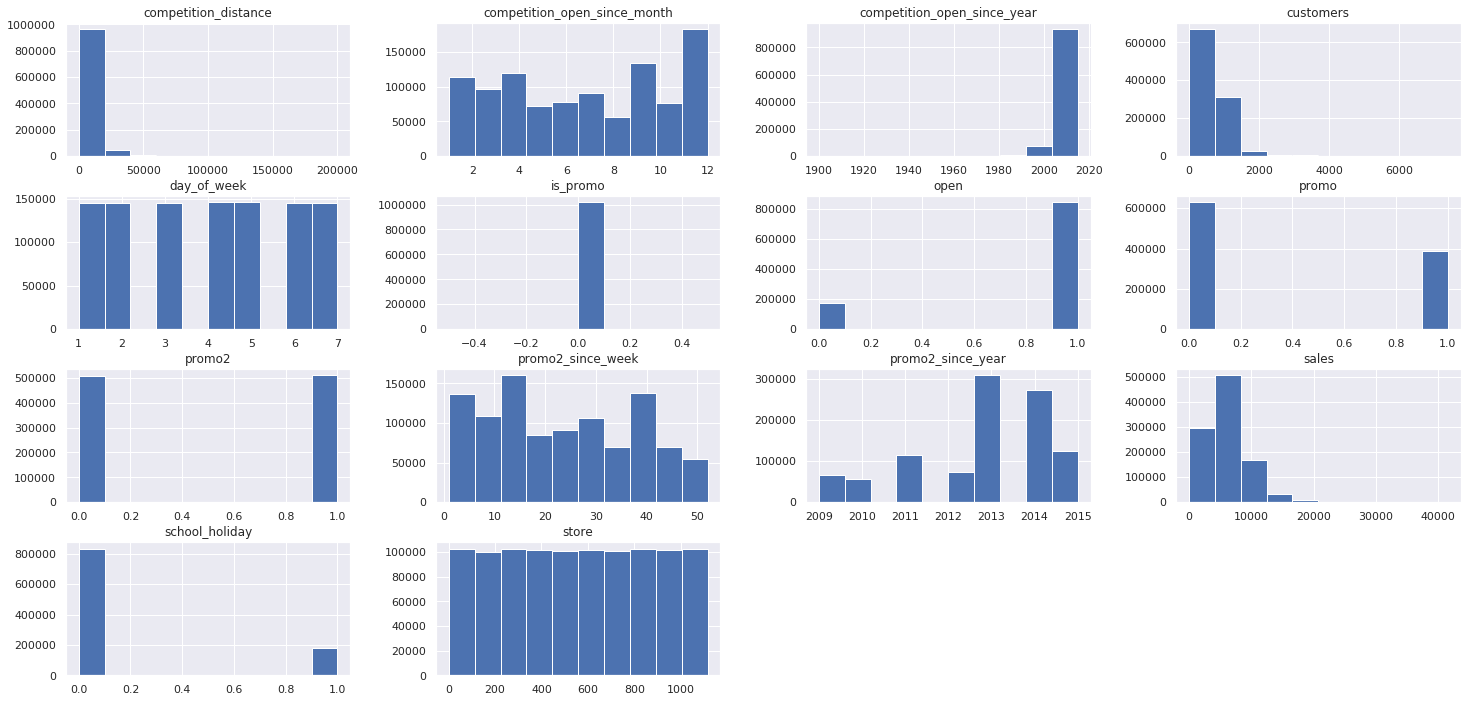

In [37]:
#cria um histograma de todas as variaveis numericas 
num_attributes.hist(bins =10 );

from matplotlib import pyplot as plt
fig1 = plt.figure(1)
plt.plot([[50,55], [60, 65]])

#fig1.set_size_inches(70, 70)


plt.show()

### 4.1.3 Categorical Variable

In [38]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

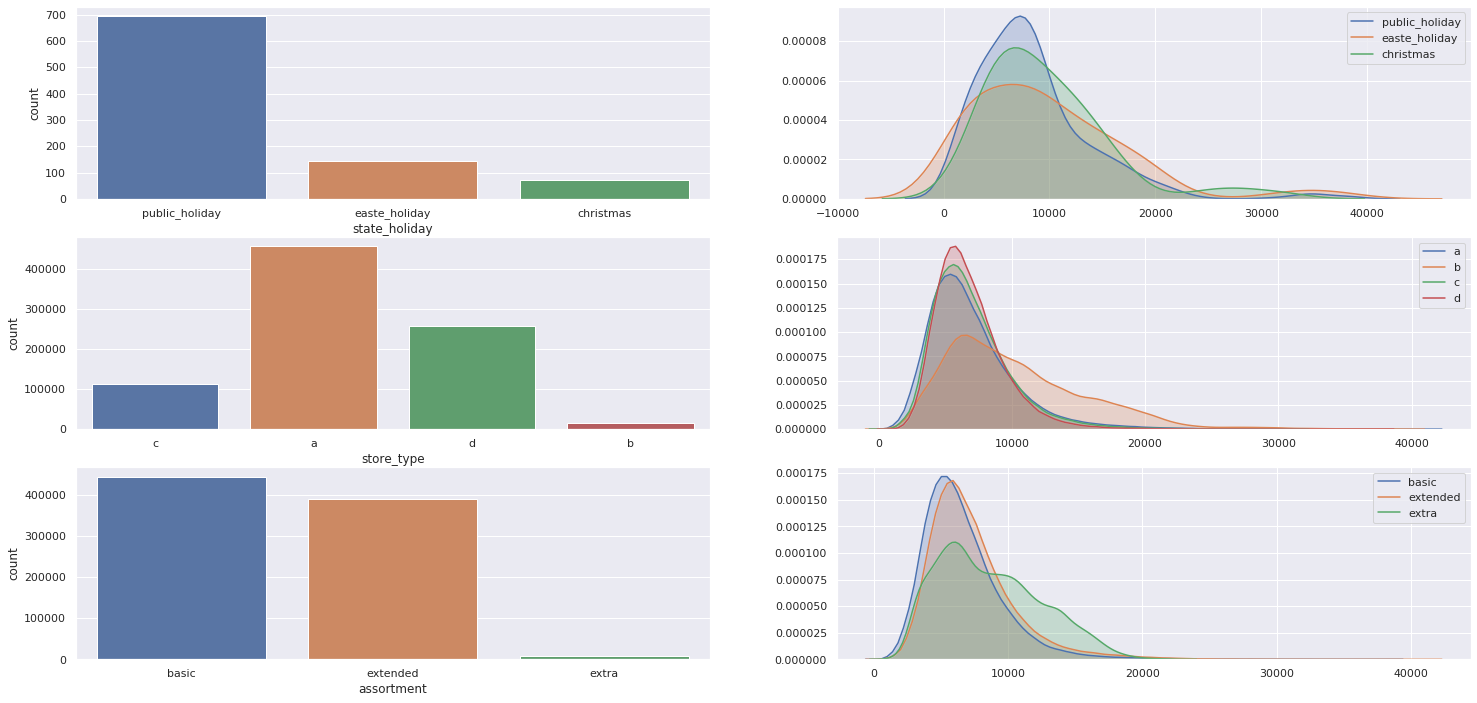

In [39]:
#fig,ax=plt.subplots(figsize=(12,12))
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easte_holiday']['sales'], label='easte_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)


#assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', shade=True)


## 4.2 Analise Bivariada

### *H1. Lojas com maior sortimentos deveriam vender mais.*
**FALSA** lojas com MAIOR SORTIMENTO vendem MENOS.




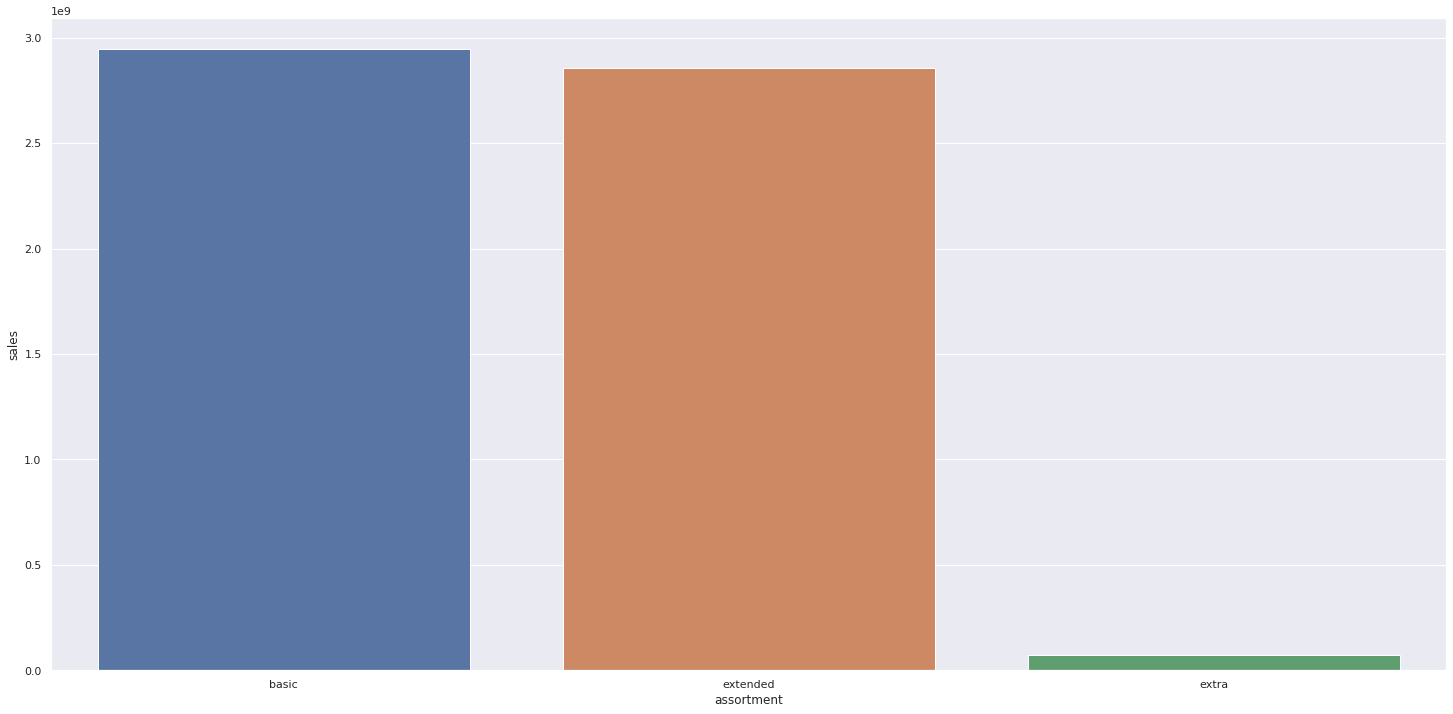

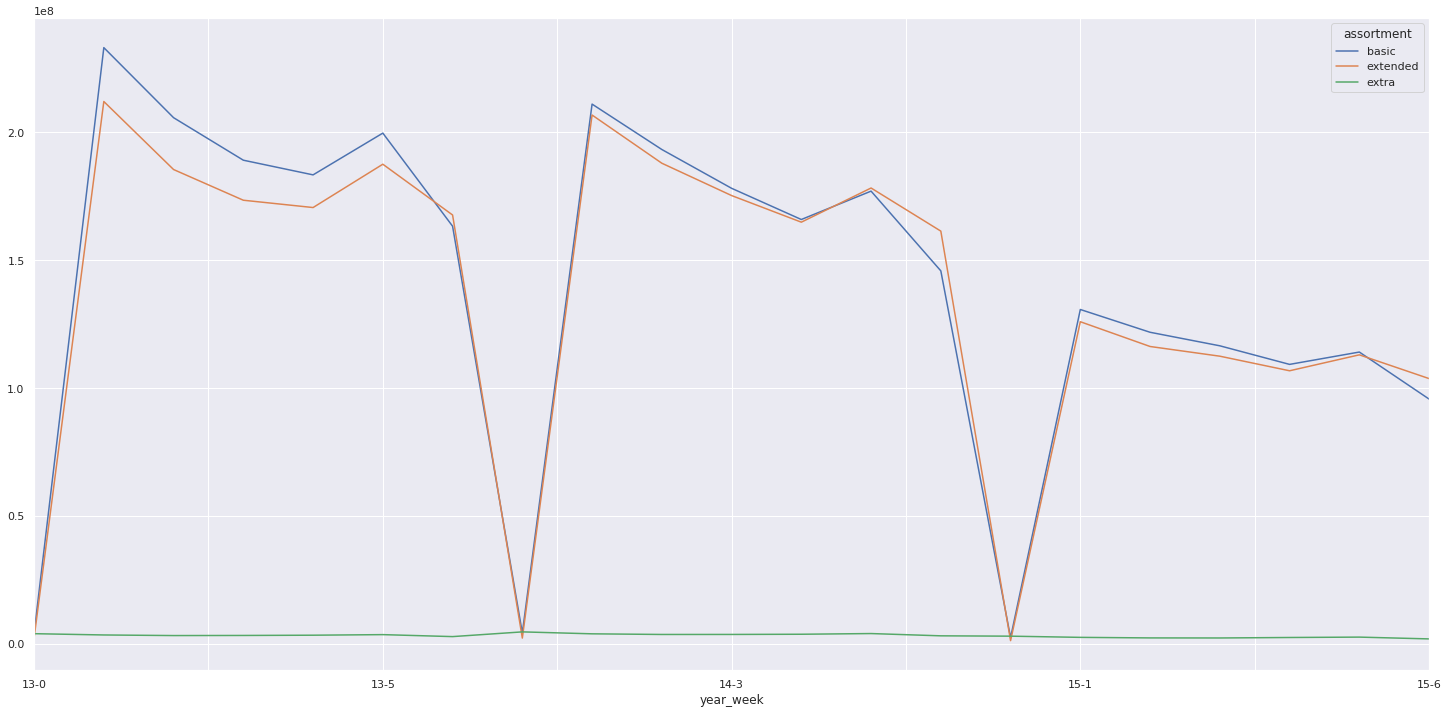

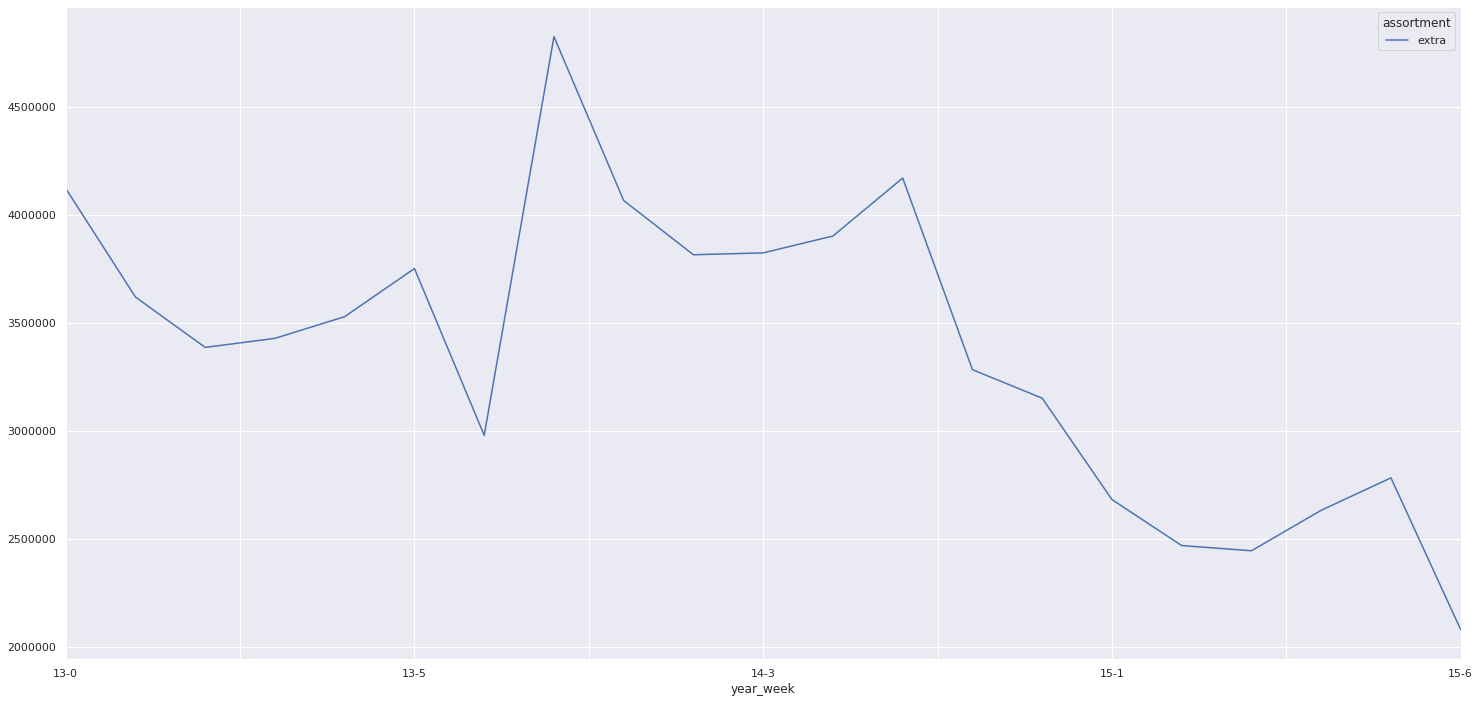

In [40]:


#agrupou os sortimentos por vendas, e somou o resultado e resetou o index
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1);

#usou o pivot para visualizar melhor o index, a coluna e o valor.
aux2= df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns ='assortment', values='sales').plot()

#plotagem do extra solo para observar seu comportamento
aux3 = aux2[aux2['assortment']== 'extra']
aux3.pivot(index ='year_week', columns= 'assortment', values='sales').plot()



### *H2. Lojas com competidores mais próximos deveriam vender menos.*
**FALSA** lojas com COMPETIDORES MAIS PROXIMOS vendes MAIS



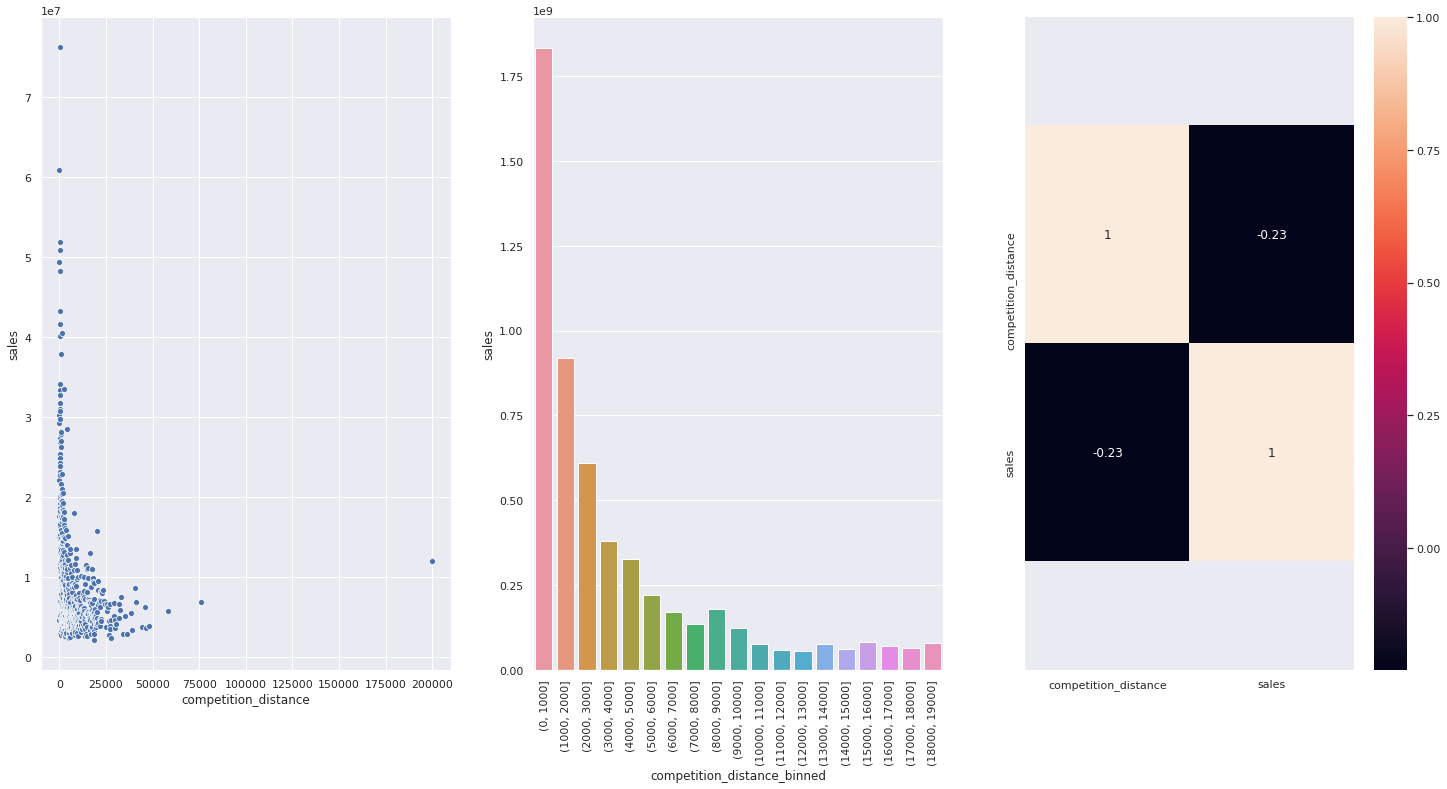

In [41]:
#para facilitar a visualização, cria-se bins com intervalo de distancia entre os pontos 
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);


plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned' , y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5 );



### *H3. Lojas com competidores à mais tempo deveriam vendem mais.*
**FALSE** LOjas com COMPETIDORE À MAIS TEMPO vendem MENOS.

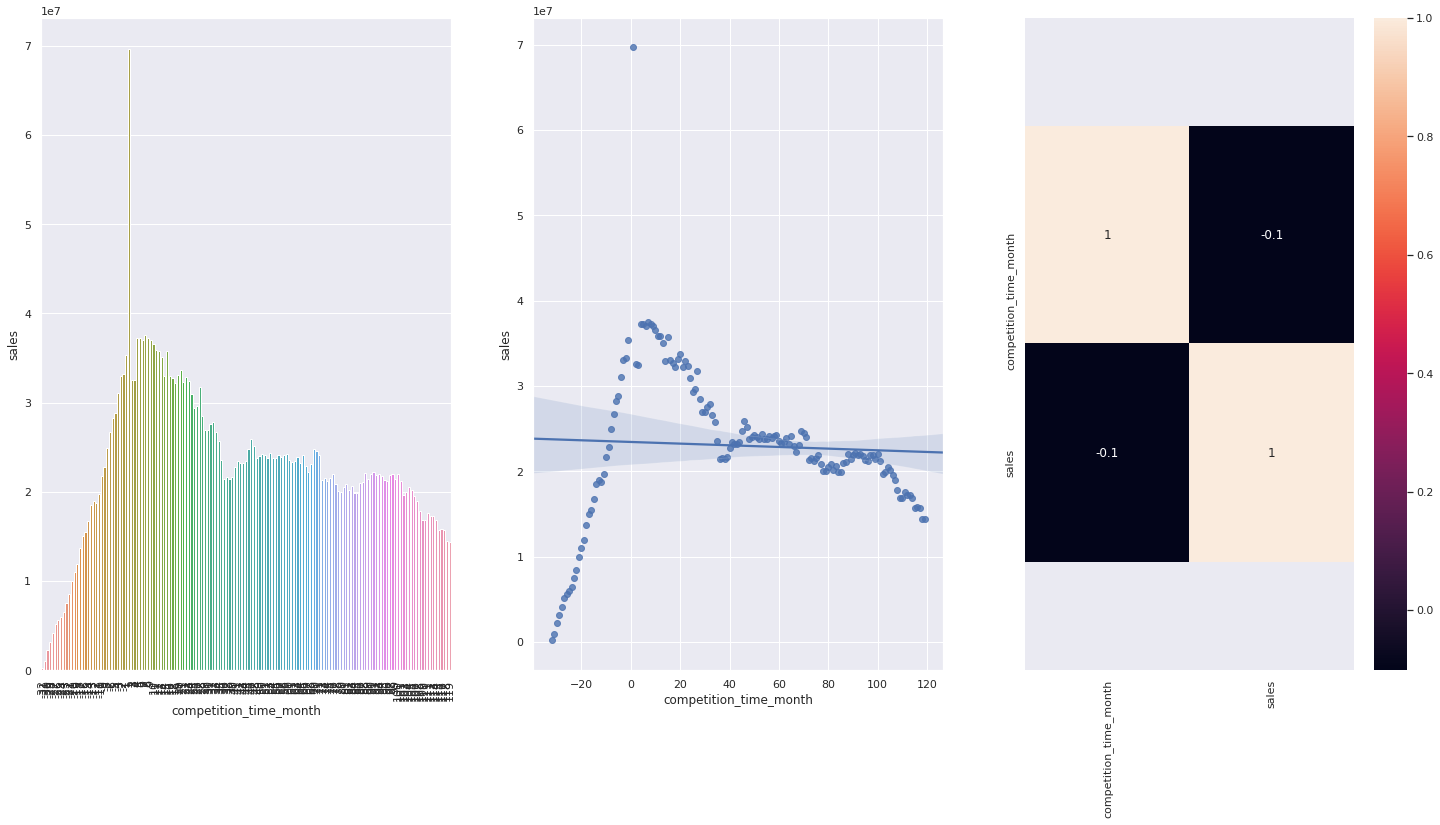

In [42]:
#por conta da grande granularidade dos dados, é necessário filtrar por os 12 primeiros meses 
#e por lojas que venderam no mesmo mês de abertura

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']< 120 ) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);


plt.subplot(1,3,2)

sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
#plt.rcParams["figure.figsize"] = (15, 15)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
botoom,top =x.get_ylim()

x.set_ylim(bottom +0.5, top-0.5);
plt.xticks(rotation=90);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

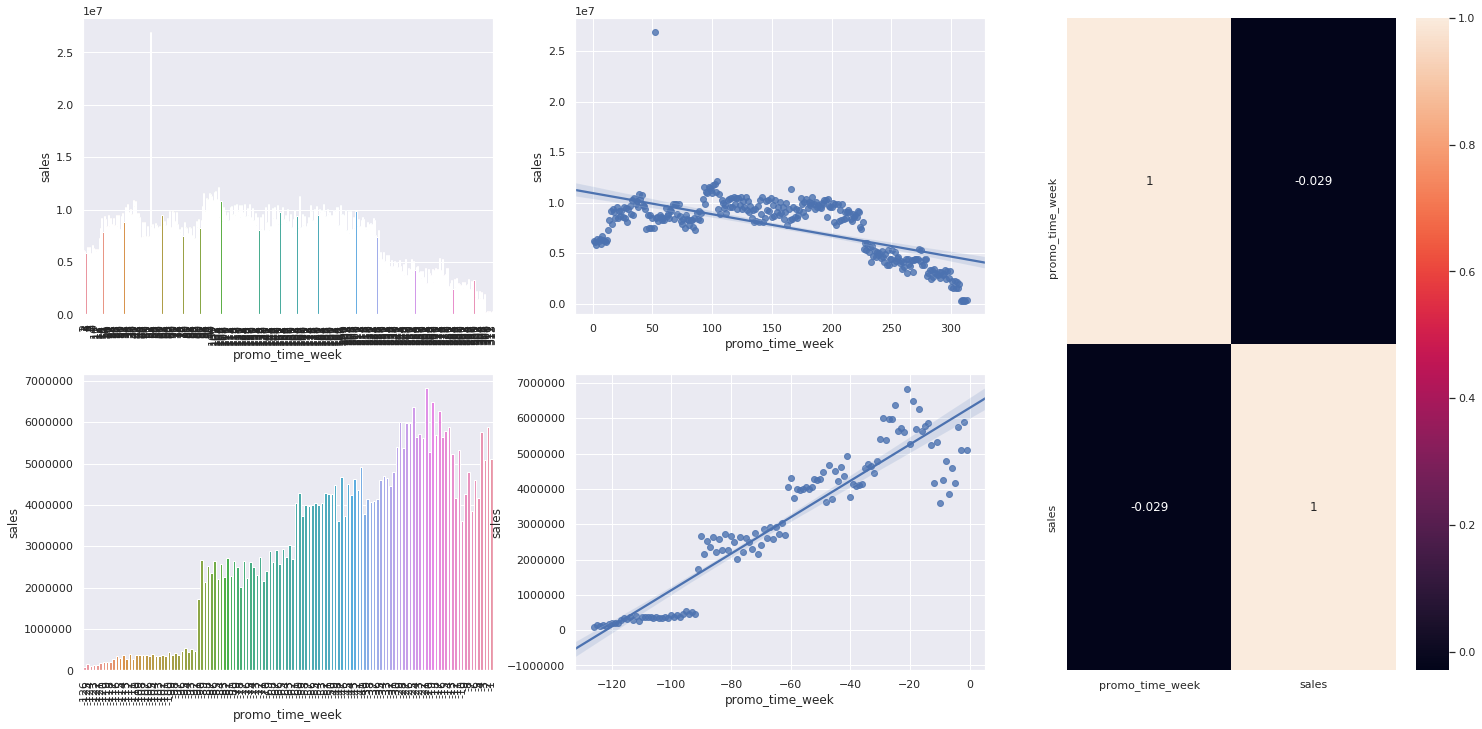

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

###. H5. Lojas com mais dias de promoção deveriam vender mais.

 ### <s>H5. Lojas com mais dias de promoção deveriam vender mais.¶</s>

### H7. Lojas com mais promoções consecutivas deveriam vender mais.¶
FALSA Lojas com mais promocoes consecutivas vendem menos

In [44]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


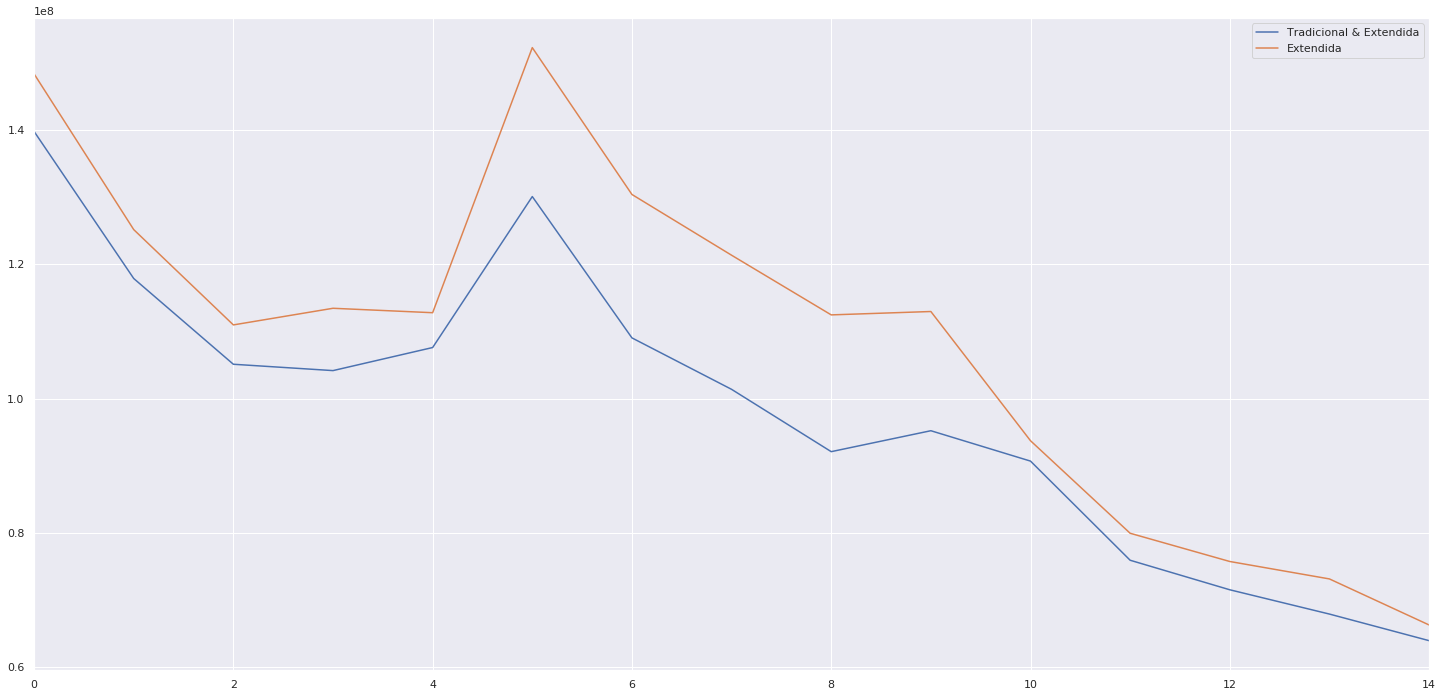

In [45]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos.



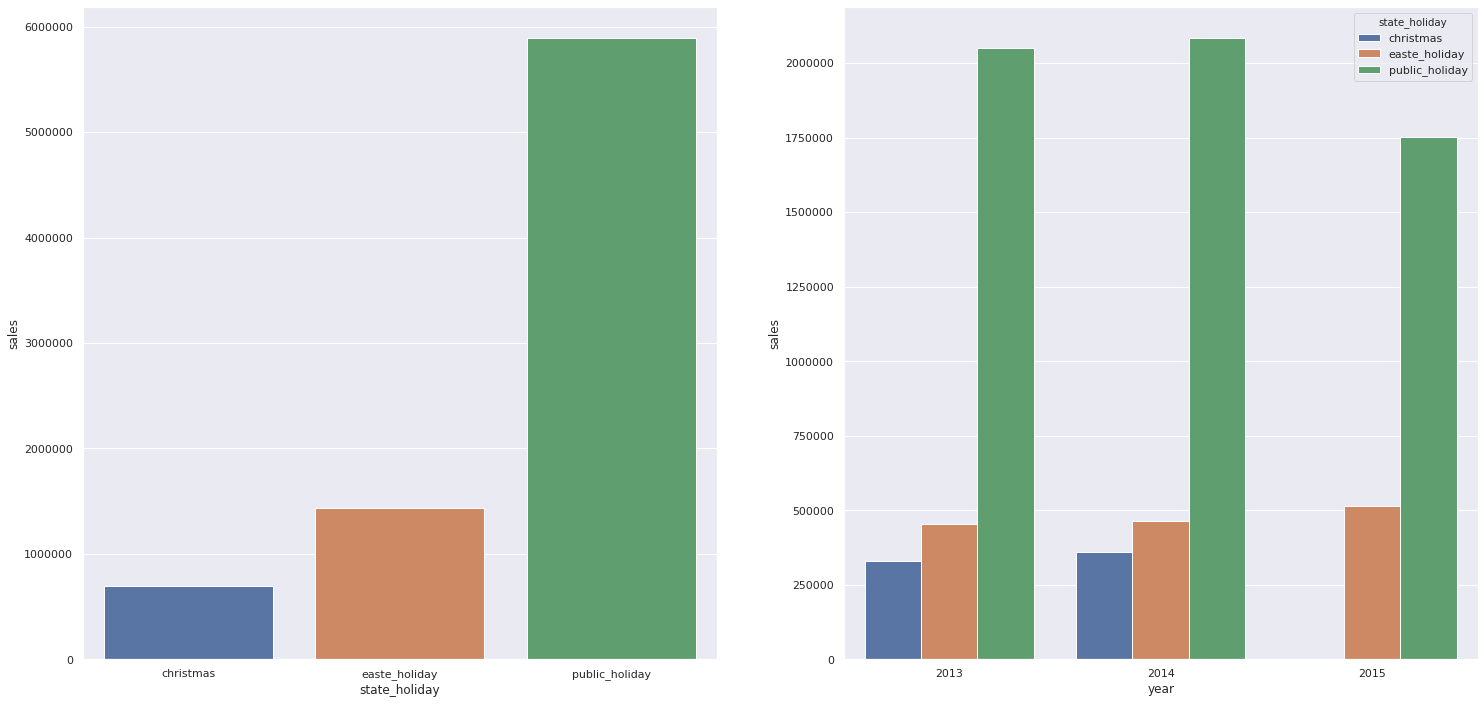

In [46]:

plt.subplot(1,2,1)
aux=df4[df4['state_holiday']!= 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)

aux2=aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### H9. Lojas deveriam vender mais ao longo dos anos.
FALSA Lojas vendem menos ao longo dos anos

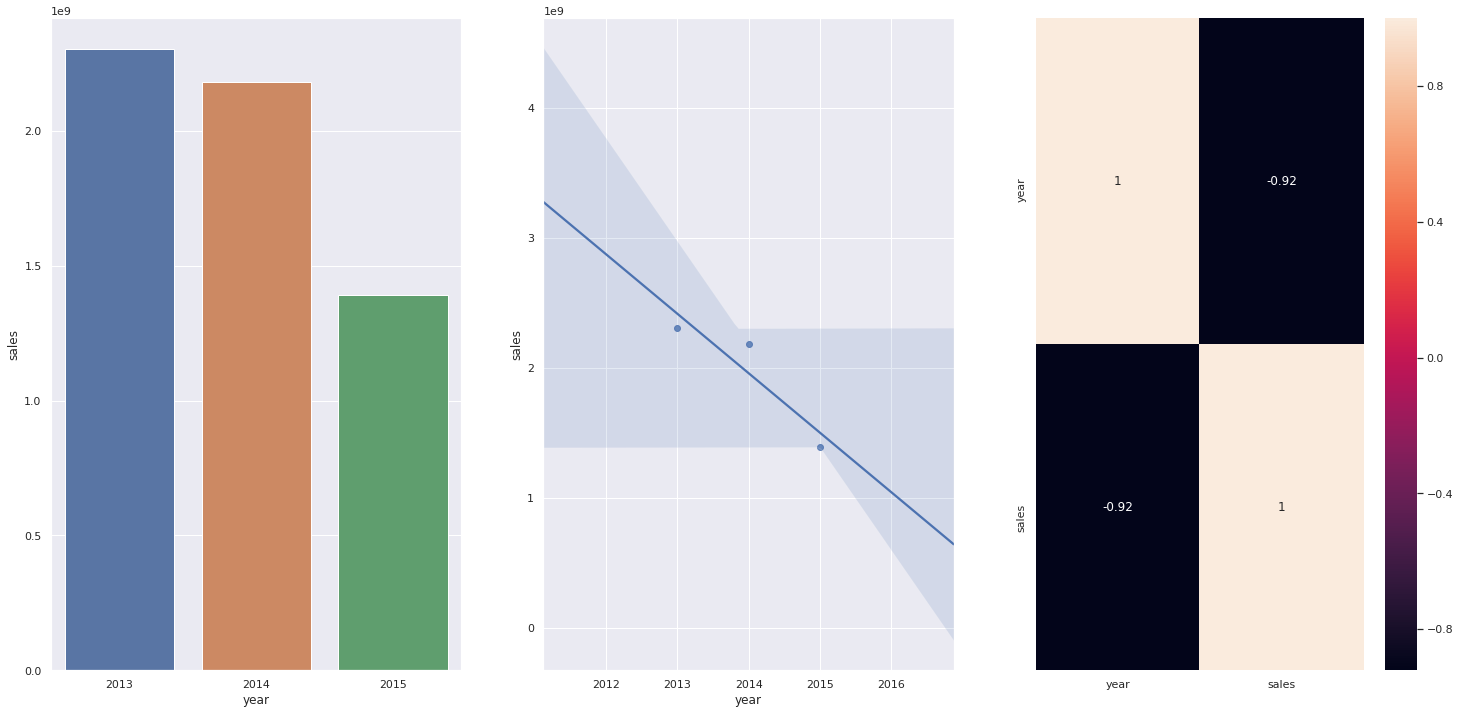

In [47]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);
#grafico para correlação 


### H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

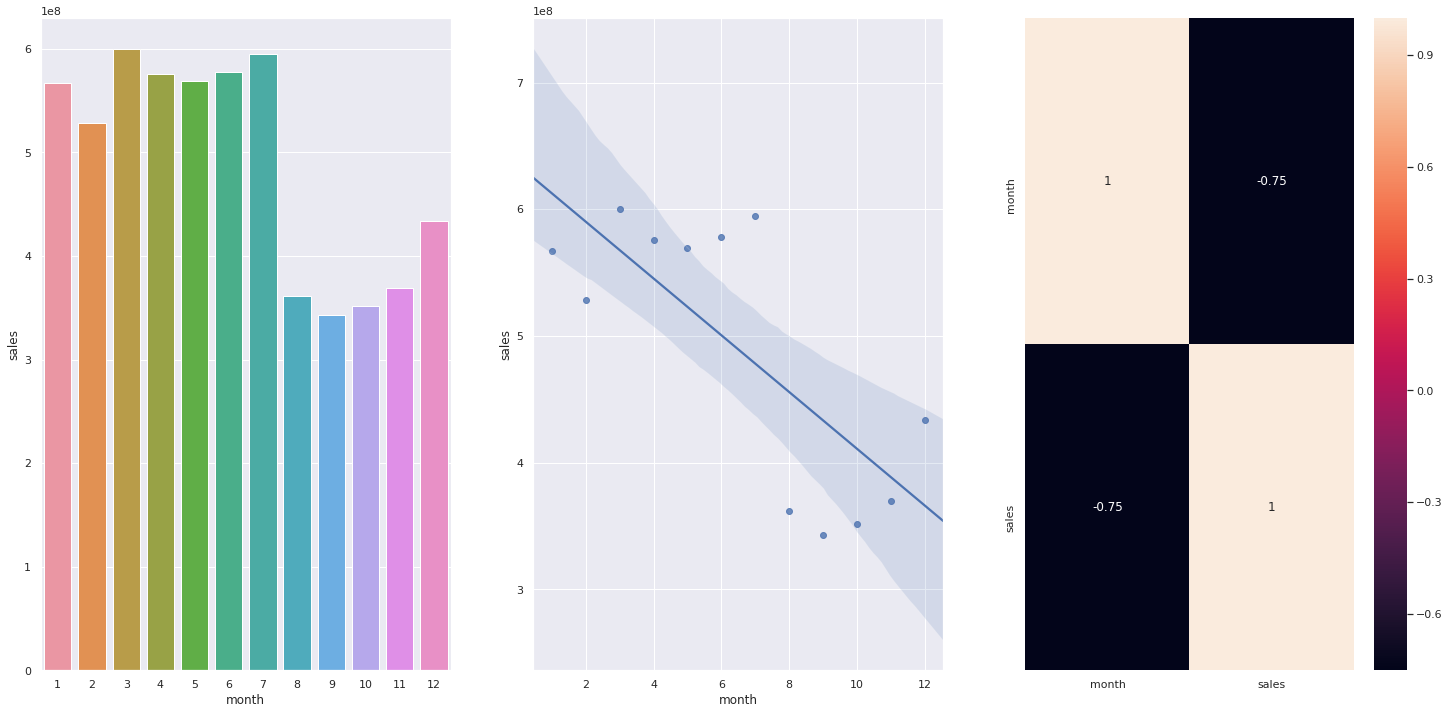

In [48]:
plt.subplot(1,3,1)

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x= 'month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.



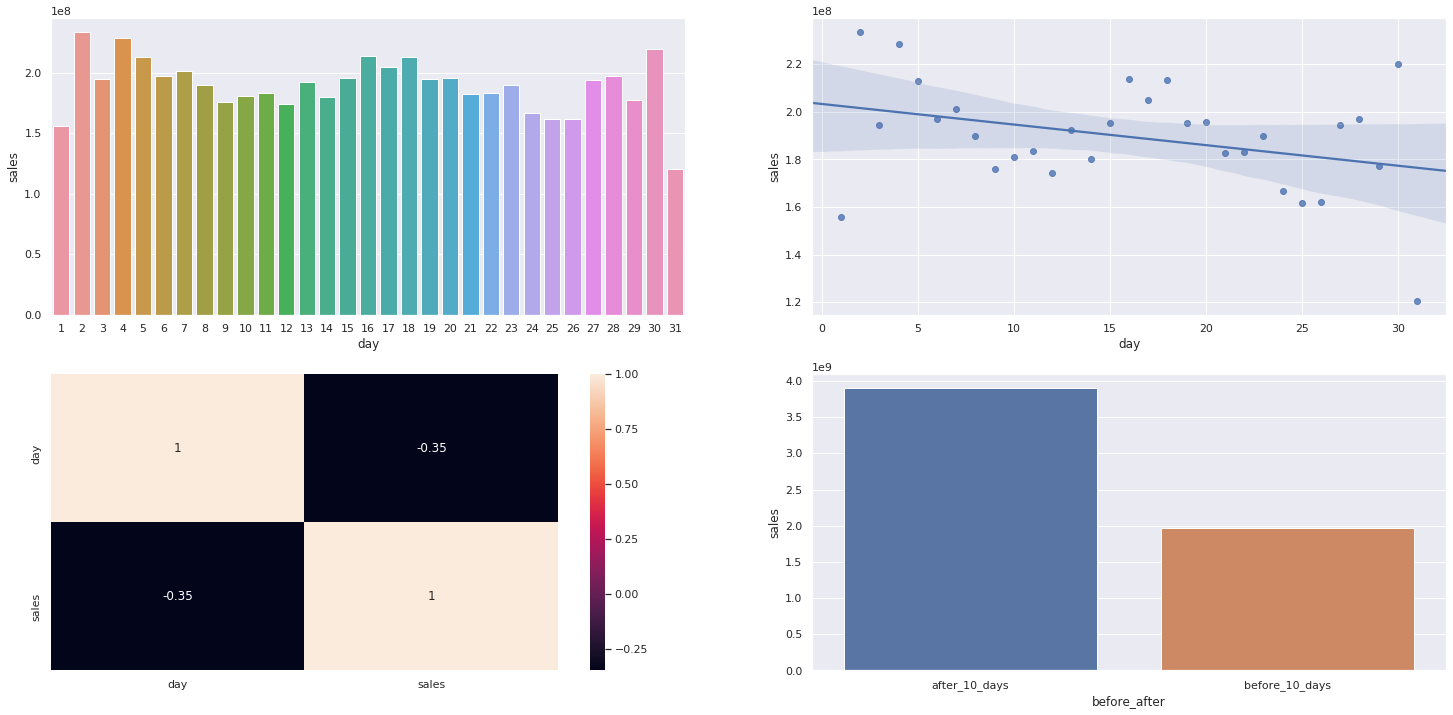

In [49]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x= 'day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)

sns.barplot(x= 'before_after', y='sales', data=aux2);

### H12. Lojas deveriam vender menos aos finais de semana.¶
VERDADEIRA Lojas vendem menos nos final de semana

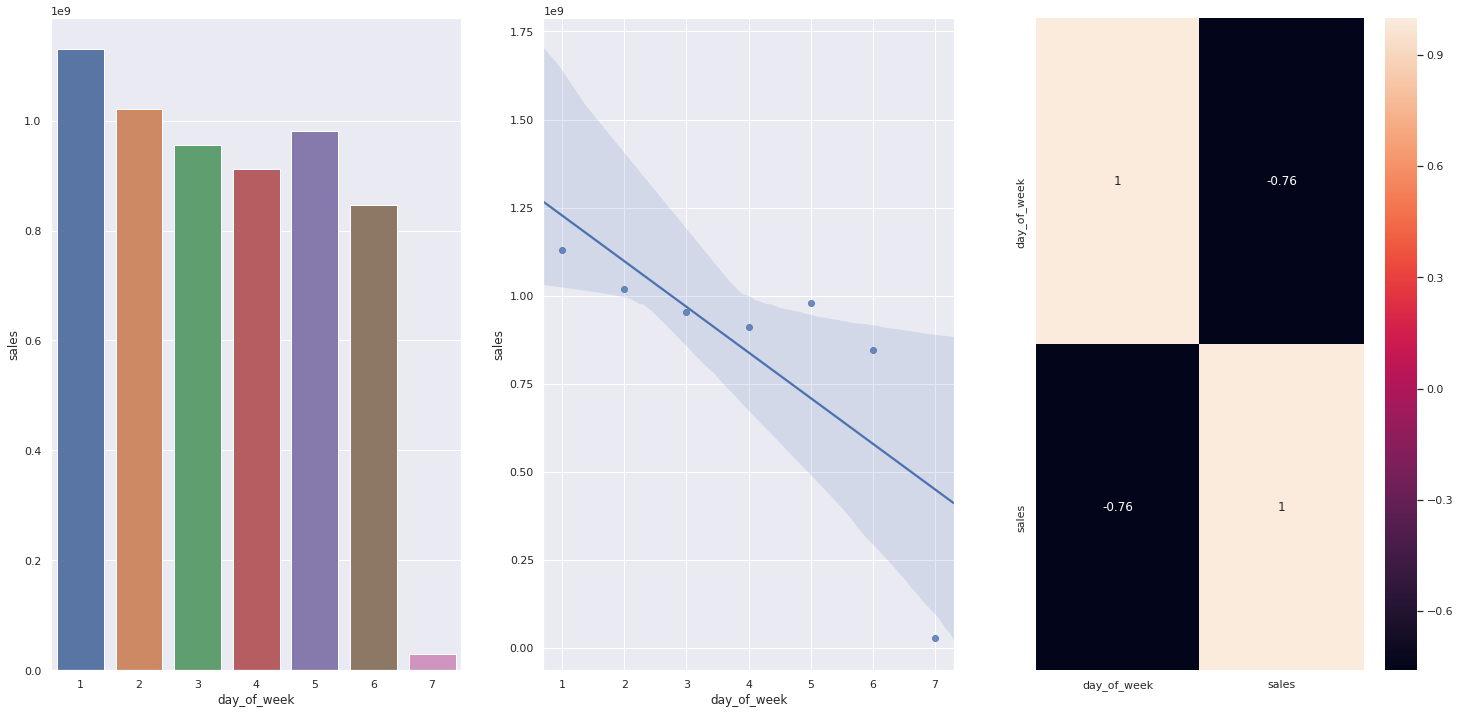

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

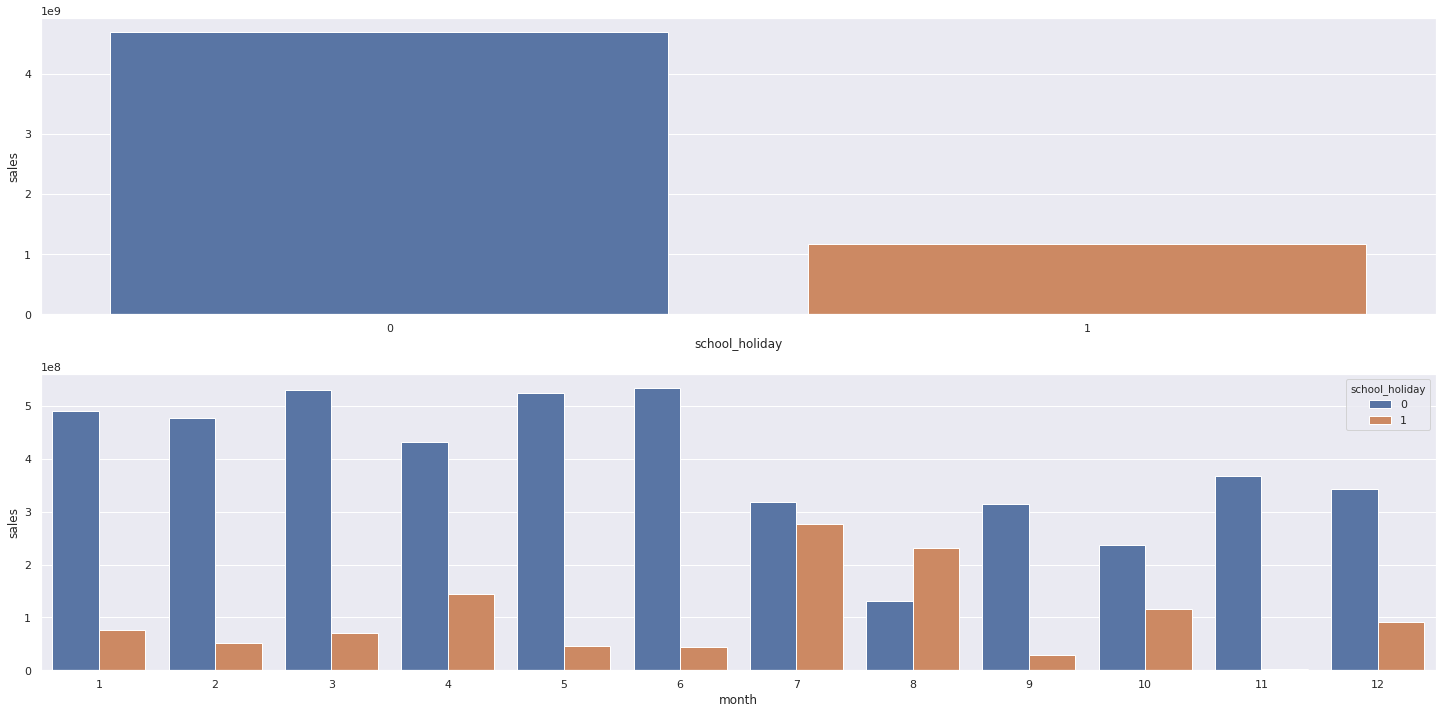

In [51]:
plt.subplot(2,1,1)

aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales',data=aux1);


plt.subplot(2,1,2)
aux2= df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue ='school_holiday', data=aux2);


### 4.2.1 Resumo das Hipoteses

In [52]:
from tabulate import tabulate

In [53]:
tab=[['Hipoteses', 'Conclusao', 'Relevancia'],
     ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
    ]
print( tabulate(tab, headers ='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1. Numerical Attributes

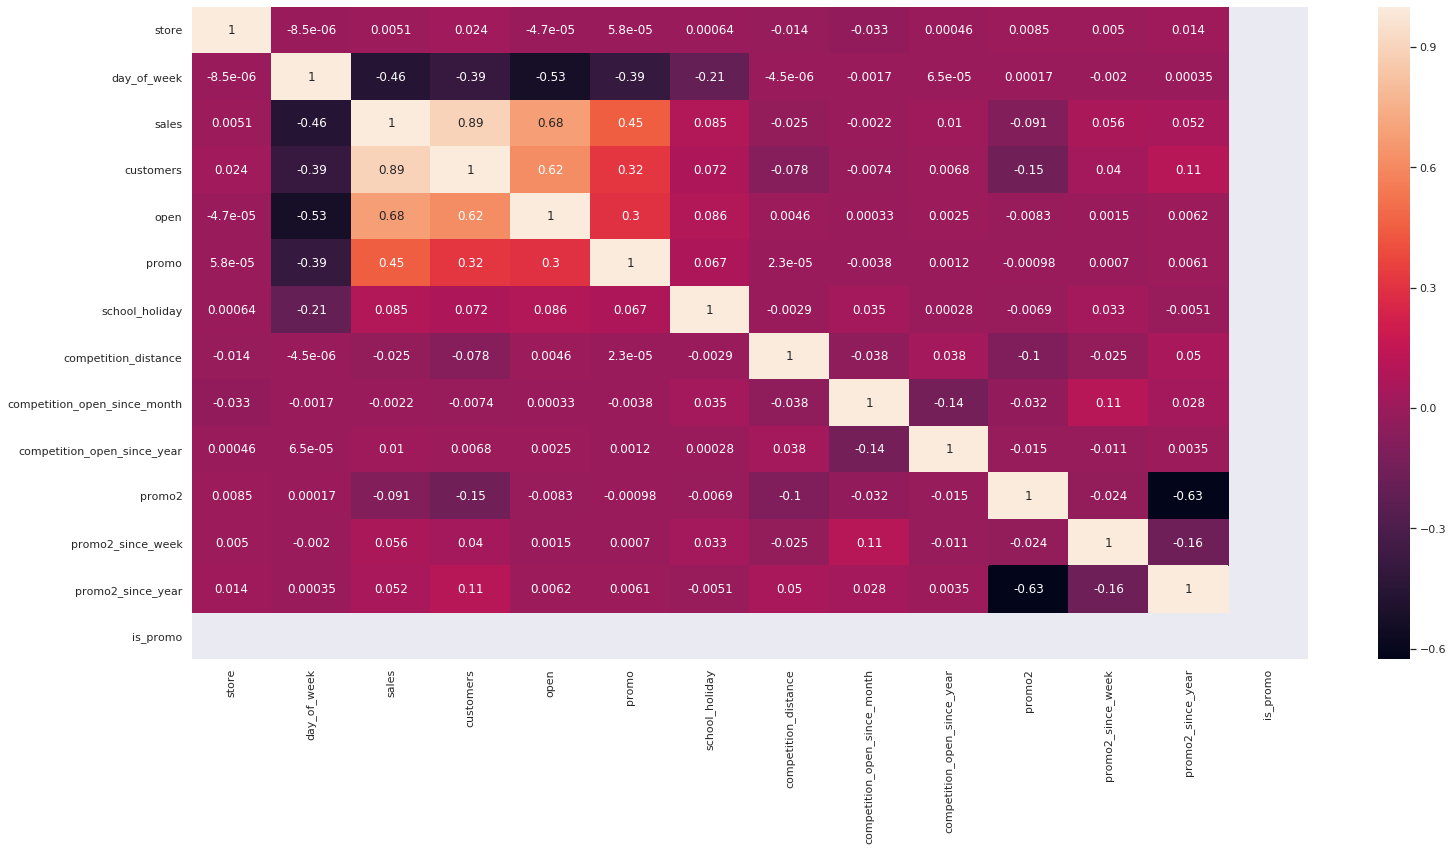

In [54]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

<ipython-input-4-d83bd5c6ac0a>:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab( x, y ).as_matrix()


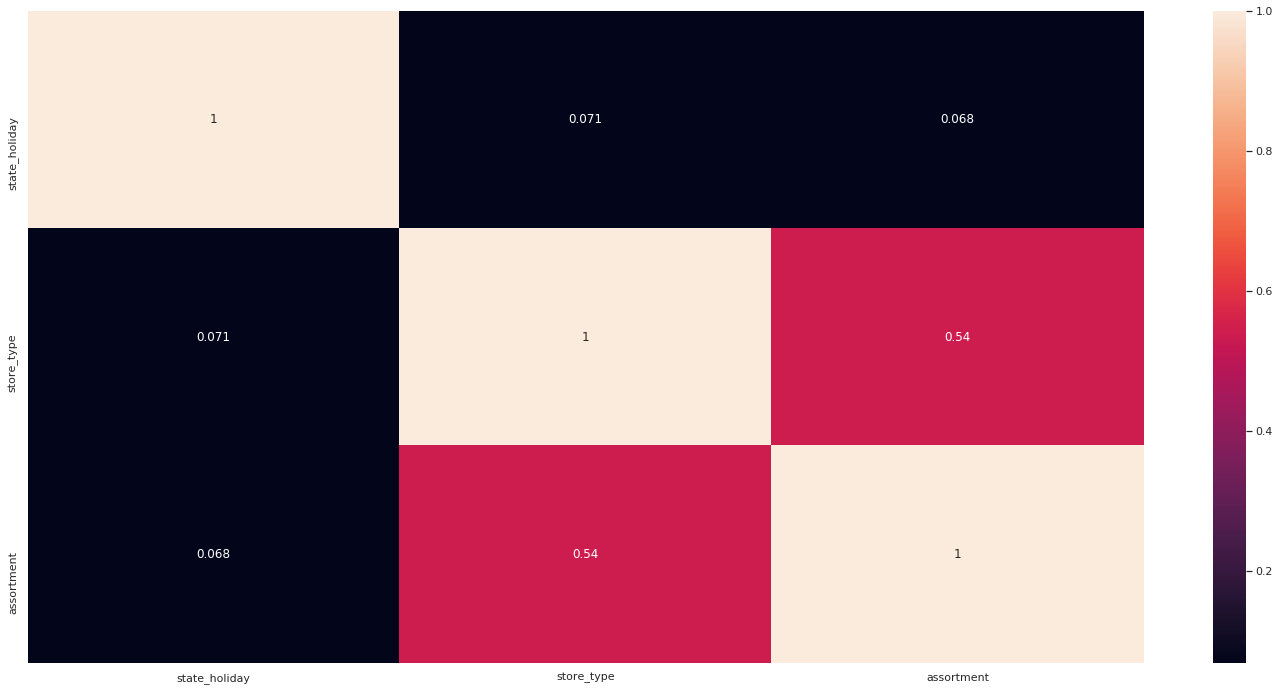

In [55]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 05 - DATA PREPARATION

In [56]:
df5=df4.copy()

In [57]:
df5.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
is_promo                        0
year                            0
month                           0
day                             0
week_of_year                    0
year_week                       0
competition_since               0
competition_time_month          0
promo_since                     0
promo_time_week                 0
dtype: int64

## 5.1. Normalizacao

## 5.2. Rescaling

In [58]:
a = df5.select_dtypes(include =['int64', 'float64'])

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )


# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )


# year
df5['year'] = mms.fit_transform( df5[['year']].values )


In [60]:
#rs = RobustScaler()
#mms = MinMaxScaler()

#usar o robustscaler e subescrever a coluna
#competition distance
#df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)


#competition time month
#df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)


#promo time week
#df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year 
#df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3. Transformacao

In [61]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,15-5,2015-31,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,0,1.0,7,31,31,15-5,2010-13,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,0,1.0,7,31,31,15-5,2011-14,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,15-5,2015-31,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,15-5,2015-31,-0.162162,2015-07-27,0.287016


### 5.3.1. Encoding

In [62]:
#state_holiday -One Hot Enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

#store_type -Label Enconding 
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment _ Ordinal Enconding 
assortment_dict ={'basic':1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)



In [63]:
# state_holiday - One Hot Encoding
#df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
#le = LabelEncoder()
#df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
#assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
#df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [64]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

In [65]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [66]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easte_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,15-5,2015-31,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,0,1.0,7,31,31,15-5,2010-13,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,0,1.0,7,31,31,15-5,2011-14,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,15-5,2015-31,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,15-5,2015-31,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [67]:
df5.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
promo                           0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
is_promo                        0
year                            0
month                           0
day                             0
week_of_year                    0
year_week                       0
competition_since               0
competition_time_month          0
promo_since                     0
promo_time_week                 0
state_holiday_christmas         0
state_holiday_easte_holiday     0
state_holiday_public_holiday    0
state_holiday_regular_day       0
month_sin                       0
month_cos     


# 6.0. PASSO 06 - FEATURE SELECTION

In [68]:
df6 = df5.copy()

## 6.1. Split dataframe into tranining and test dataset

In [69]:
cols_drop =['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [70]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [71]:
#training 
#x_train_n = x_train.drop(['date','sales'], axis =1).values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor 
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators ='auto', verbose= 2, random_state=42).fit(x_train_n,y_train_n)

### 6.2.1. Best Features from Boruta

In [72]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [73]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [74]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [75]:
#todas columnas mais relevantes segundo o boruta.

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [76]:
#modelo de media

aux1= x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1 [['store', 'sales' ]].groupby('store').mean().reset_index().rename(columns ={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions'] #valor da predicao


#performace
#os valores foram transformados com log, para voltar ao normal precisa aplicar o exponecial
baseline_result = ml_error('Avarege Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [77]:
#model 
lr = LinearRegression().fit( x_train, y_train )

#prediction
yhat_lr = lr.predict( x_test )

#performance
lr_result = ml_error('Linear Regression', np.expm1( y_test), np.expm1( yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3. Linear Regression Regularized Model - Lasso

In [79]:
#model 
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## 7.4. Random Forest Regressor

In [88]:
# model
#rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
#yhat_rf = rf.predict( x_test )

# performance
#rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
#rf_result

KeyboardInterrupt: 

### 7.4.1.  Random Forest Regressor - Cross Validation

In [81]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
#rf_result_cv

## 7.5. XGBoost Regressor

In [82]:
# model
#model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              #n_estimators=100, 
                              #eta=0.01, 
                              #max_depth=10, 
                              #subsample=0.7,
                              #colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
#yhat_xgb = model_xgb.predict( x_test )

# performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
#xgb_result

### 7.5.1. XGBoost Regressor - Cross Validatio

In [83]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [86]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

NameError: name 'rf_result' is not defined

###  7.6.2. Real Performance - Cross Validation

In [85]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv